In [1]:
from google.colab import drive; drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd
dataset_path = '/content/drive/My Drive/mhealth_balanced_preprocessed.csv'
data = pd.read_csv(dataset_path)
data.head()

<ipython-input-2-122c339f93a3>:3: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dataset_path)


,chest_acc_x,chest_acc_y,chest_acc_z,ecg_1,ecg_2,ankle_acc_x,ankle_acc_y,ankle_acc_z,ankle_gyro_x,ankle_gyro_y,...,arm_acc_x,arm_acc_y,arm_acc_z,arm_gyro_x,arm_gyro_y,arm_gyro_z,arm_mag_x,arm_mag_y,arm_mag_z,label
0,-0.082298,0.100707,-0.109697,-0.040645,0.012529,-0.318837,0.209841,0.381243,-0.626800,-0.331064,...,0.308429,-0.396686,-0.247928,-1.055188,-0.385007,-0.283994,0.030973,-0.085350,-0.009639,standing_sitting
1,-0.145185,-0.058681,0.080943,0.029537,0.028832,-0.186470,0.240070,0.443979,0.477669,-0.021467,...,0.434662,-0.381911,0.396716,0.814344,-0.407283,1.095761,0.042972,-0.075806,0.002653,standing_sitting
2,-0.079641,-0.191486,0.010085,0.141002,0.138880,-0.160918,0.264784,0.482819,0.498755,0.066031,...,0.443040,-0.372538,0.383792,0.850914,-0.389458,1.118194,0.027122,-0.071250,-0.006657,standing_sitting
3,-0.131824,0.024539,0.401956,2.163932,0.974429,-0.423189,0.234660,0.427225,-1.208550,-0.021467,...,0.329354,-0.390973,0.021780,-1.009473,-0.402832,-0.340085,0.035511,-0.019771,0.005469,standing_sitting
4,-0.126107,0.260801,0.649338,-0.048902,0.053287,-0.267000,0.247715,0.370905,1.228038,-0.203171,...,0.247260,-0.317893,0.265003,1.093174,-0.656953,0.991055,0.022950,-0.094383,-0.003555,standing_sitting


In [3]:
from sklearn.preprocessing import LabelEncoder

data["label"] = data["label"].astype(str)

X = data.drop(columns=["label"]).values
y = data["label"].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Label mappings:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
print("Features shape:", X.shape)
print("Labels shape:", y_encoded.shape)


Label mappings: {'0': 0, 'jogging': 1, 'running': 2, 'standing_sitting': 3, 'walking': 4}
Features shape: (153600, 23)
Labels shape: (153600,)


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)


Training set shape: (107520, 23) (107520,)
Validation set shape: (23040, 23) (23040,)
Test set shape: (23040, 23) (23040,)


In [9]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print("LSTM input shapes:")
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)


LSTM input shapes:
X_train: (107520, 1, 23)
X_val: (23040, 1, 23)
X_test: (23040, 1, 23)


In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, ReLU, Add, Dropout,
    MaxPooling1D, GlobalAveragePooling1D, Dense, LSTM, Bidirectional, Attention
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization

# Residual Block for Convolutional Layers
def residual_block(x, filters, kernel_size, strides=1):
    shortcut = x
    x = Conv1D(filters, kernel_size, padding='same', strides=strides)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv1D(filters, kernel_size, padding='same', strides=strides)(x)
    x = BatchNormalization()(x)
    if shortcut.shape[-1] != x.shape[-1]:
        shortcut = Conv1D(filters, kernel_size=1, strides=1, padding='same')(shortcut)
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# CNN Layers with Residual Connections
x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2, strides=2, padding='same')(x)

x = residual_block(x, filters=128, kernel_size=3)
x = MaxPooling1D(pool_size=2, strides=2, padding='same')(x)

x = residual_block(x, filters=256, kernel_size=3)
x = MaxPooling1D(pool_size=2, strides=2, padding='same')(x)

# Bi-LSTM for Temporal Modeling
x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.3))(x)
x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.3))(x)

# Self-Attention Mechanism
attention_output = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
attention_output = LayerNormalization()(attention_output + x)  # Add residual connection

# Final Temporal Pooling
x = GlobalAveragePooling1D()(attention_output)

# Fully Connected Layers
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.4)(x)


output_layer = Dense(len(label_encoder.classes_), activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 1, 23)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_10 (Conv1D)        │ (None, 1, 64)          │          4,480 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 1, 64)          │            256 │ conv1d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_6           │ (None, 1, 64)          │              0 │ batch_normalization_8… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_11 (Conv1D)        │ (None, 1, 128)         │         24,704 │ max_pooling1d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 1, 128)         │            512 │ conv1d_11[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_4 (ReLU)            │ (None, 1, 128)         │              0 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_12 (Conv1D)        │ (None, 1, 128)         │         49,280 │ re_lu_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 1, 128)         │            512 │ conv1d_12[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_13 (Conv1D)        │ (None, 1, 128)         │          8,320 │ max_pooling1d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 1, 128)         │              0 │ batch_normalization_1… │
│                           │                        │                │ conv1d_13[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_5 (ReLU)            │ (None, 1, 128)         │              0 │ add_3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_7           │ (None, 1, 128)         │              0 │ re_lu_5[0][0]          │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_14 (Conv1D)        │ (None, 1, 256)         │         98,560 │ max_pooling1d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 1, 256)         │          1,024 │ conv1d_14[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_6 (ReLU)       

 Total params: 1,134,469 (4.33 MB)

 Trainable params: 1,132,805 (4.32 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [15]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25, 
    batch_size=32,
    verbose=1
)


Epoch 1/25
3360/3360 ━━━━━━━━━━━━━━━━━━━━ 159s 43ms/step - accuracy: 0.6573 - loss: 0.8876 - val_accuracy: 0.9326 - val_loss: 0.2117
Epoch 2/25
3360/3360 ━━━━━━━━━━━━━━━━━━━━ 197s 42ms/step - accuracy: 0.9091 - loss: 0.2850 - val_accuracy: 0.9488 - val_loss: 0.1549
Epoch 3/25
3360/3360 ━━━━━━━━━━━━━━━━━━━━ 138s 41ms/step - accuracy: 0.9334 - loss: 0.2168 - val_accuracy: 0.9560 - val_loss: 0.1349
Epoch 4/25
3360/3360 ━━━━━━━━━━━━━━━━━━━━ 144s 42ms/step - accuracy: 0.9467 - loss: 0.1834 - val_accuracy: 0.9626 - val_loss: 0.1213
Epoch 5/25
3360/3360 ━━━━━━━━━━━━━━━━━━━━ 140s 41ms/step - accuracy: 0.9514 - loss: 0.1643 - val_accuracy: 0.9643 - val_loss: 0.1155
Epoch 6/25
3360/3360 ━━━━━━━━━━━━━━━━━━━━ 137s 41ms/step - accuracy: 0.9565 - loss: 0.1509 - val_accuracy: 0.9661 - val_loss: 0.1105
Epoch 7/25
3360/3360 ━━━━━━━━━━━━━━━━━━━━ 141s 41ms/step - accuracy: 0.9599 - loss: 0.1400 - val_accuracy: 0.9668 - val_loss: 0.1099
Epoch 8/25
3360/3360 ━━━━━━━━━━━━━━━━━━━━ 149s 43ms/step - accuracy: 

In [16]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Test Loss: 0.07769971340894699
Test Accuracy: 0.9792534708976746


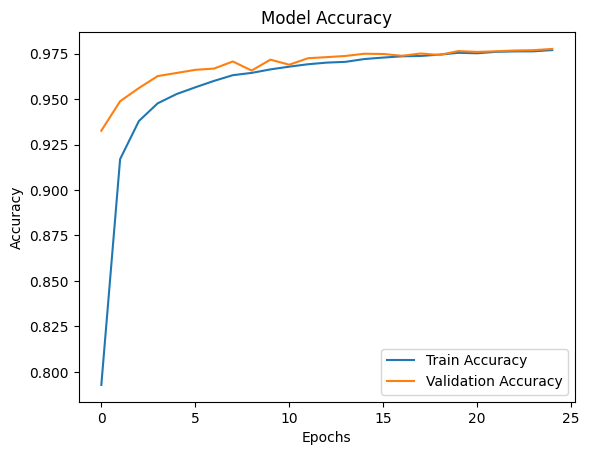

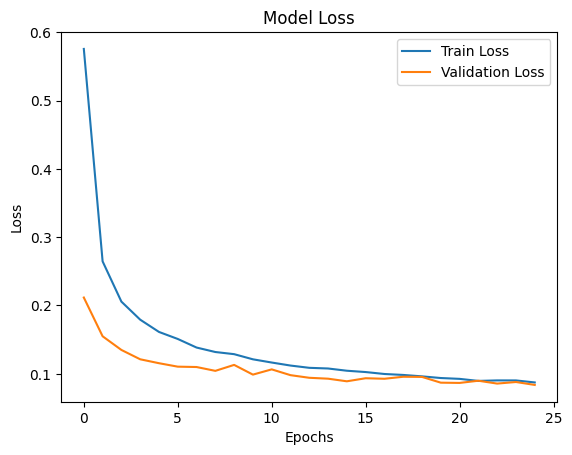

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [18]:
import numpy as np

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))


720/720 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
                  precision    recall  f1-score   support

               0       1.00      0.93      0.96      4608
         jogging       0.97      0.99      0.98      4608
         running       0.98      0.98      0.98      4608
standing_sitting       0.98      1.00      0.99      4608
         walking       0.97      1.00      0.99      4608

        accuracy                           0.98     23040
       macro avg       0.98      0.98      0.98     23040
    weighted avg       0.98      0.98      0.98     23040

